# 学习率与优化器
在本例中，通过比较**同样结构**，**同样优化器**，**同样数据集**下**不同优化器**以及**不同初始学习率**下训练的值得出优化器与初始学习率对训练的影响。


在模型训练过程中涉及到一个关键概念——学习率。学习率代表着模型学习的速率，学习率的值越大，损失函数的变化速度越快。较高的学习率大小可以使模型快速收敛，但是可能会导致模型在局部极小值周围震荡无法很好收敛。较小的学习率虽然可以让模型在局部极小值周围收敛，但是收敛速度很慢。所以合理的学习率是在底部使用大学习率，在顶部使用小学习率来进行梯度下降。

对于学习率这样十分重要但是调整难度很大的参数，有几种自适应学习率算法进行学习率的调整。
下面我们采用不同的优化器对相同的模型结构和数据集训练情况下进行训练。我们选择的不同的优化器为：
- rmsprop
- adam
- SGD（stochastic gradient descent）

这些自适应学习率算法不需要开发者进行学习率的设置而是模型在训练过程中进行学习率的衰减。

## 引入相关的包

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image

Using TensorFlow backend.


## 加载数据

In [2]:
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [3]:
(x_train, y_train) = load_data()
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


## 数据处理

In [4]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [6]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


## 构建模型

In [5]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [7]:
base_model = VGG16(weights=None, include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

## 定义优化器

### rmsprop
在下面的测试中，我们使用优化器为**rmsprop**，训练轮数为5，可以看到训练初期的模型指数变化情况。

In [9]:
import keras 
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=30, verbose=1, mode='auto')
callbacks = [es]

开始训练

In [11]:
history_rmsprop = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=5, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 开始训练
                  initial_epoch=0, 
                 )

Instructions for updating:
Use tf.cast instead.
Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 101s 5ms/step - loss: 0.6836 - acc: 0.5804 - val_loss: 0.6370 - val_acc: 0.6264
Epoch 2/5
18750/18750 [==============================] - 94s 5ms/step - loss: 0.6263 - acc: 0.6580 - val_loss: 0.6133 - val_acc: 0.6475
Epoch 3/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.5807 - acc: 0.7034 - val_loss: 0.5195 - val_acc: 0.7590
Epoch 4/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.5295 - acc: 0.7459 - val_loss: 0.5027 - val_acc: 0.7562
Epoch 5/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.4767 - acc: 0.7809 - val_loss: 0.4398 - val_acc: 0.7997


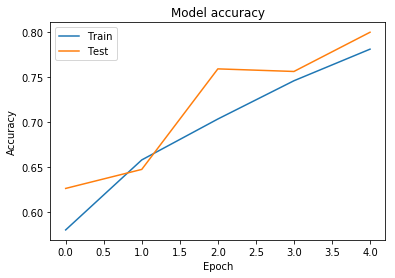

In [27]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history_rmsprop.history['acc'])
plt.plot(history_rmsprop.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

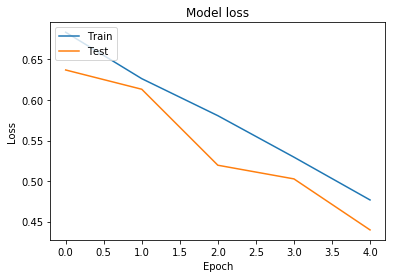

In [13]:
# 绘制训练 & 验证的损失值
plt.plot(history_rmsprop.history['loss'])
plt.plot(history_rmsprop.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Adam
在下面的例子中，加载新的模型，使用**优化器Adam**，训练轮数为5，可以看到训练初期的模型指数变化情况。

In [14]:
base_model = VGG16(weights=None, include_top=False)
model_adam = build_model(base_model)
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model_adam.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


开始训练

In [15]:
history_adam = model_adam.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=5, 
                  verbose=1, 
                  callbacks=callbacks, 
                   validation_split=0.25,  
                  shuffle=True, 
                  initial_epoch=0
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 94s 5ms/step - loss: 0.6930 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.4899
Epoch 2/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6933 - val_acc: 0.4899
Epoch 3/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.6905 - acc: 0.5261 - val_loss: 0.6866 - val_acc: 0.5712
Epoch 4/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.6768 - acc: 0.5705 - val_loss: 0.6427 - val_acc: 0.6205
Epoch 5/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.6175 - acc: 0.6589 - val_loss: 0.5902 - val_acc: 0.6858


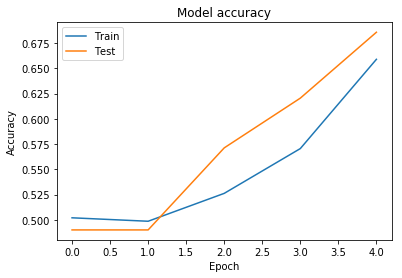

In [16]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history_adam.history['acc'])
plt.plot(history_adam.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

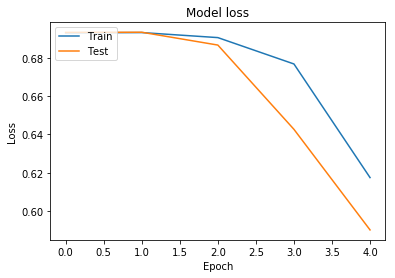

In [17]:
# 绘制训练 & 验证的损失值
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### SGD
在下面的例子中，加载新的模型，使用**优化器SGD**，训练轮数为5，可以看到训练初期的模型指数变化情况。可以看到SGD作为随机梯度下降模型，在训练初期较少的轮数下，表现并不稳定。

In [18]:
base_model = VGG16(weights=None, include_top=False)
model_sgd = build_model(base_model)
opt = keras.optimizers.SGD(lr=0.0001, decay=1e-6)
model_sgd.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


开始训练

In [19]:
history_sgd = model_sgd.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=5, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25,
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 93s 5ms/step - loss: 0.6931 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5130
Epoch 2/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6931 - acc: 0.5181 - val_loss: 0.6931 - val_acc: 0.5403
Epoch 3/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6931 - acc: 0.5077 - val_loss: 0.6931 - val_acc: 0.4901
Epoch 4/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6931 - acc: 0.5036 - val_loss: 0.6931 - val_acc: 0.4899
Epoch 5/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6931 - acc: 0.5034 - val_loss: 0.6931 - val_acc: 0.4899


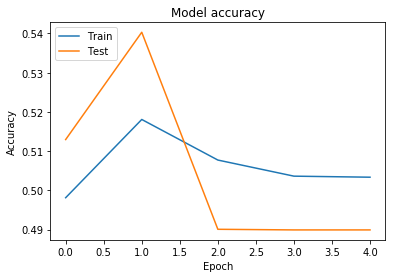

In [20]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history_sgd.history['acc'])
plt.plot(history_sgd.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

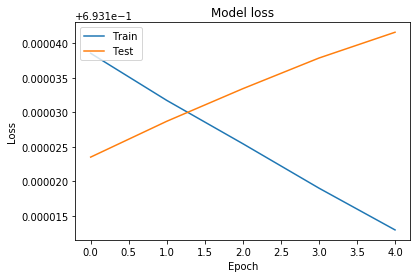

In [21]:
# 绘制训练 & 验证的损失值
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**下面的训练中学习率的初始赋值与上一次训练相比由0.0001变为0.001**
下面的训练结果并不出色，对比我们之前的Adam优化器，这次的训练几乎没有收敛。因为过大的学习率，导致模型在局部最优附近震荡，无法获得好的结果。

In [23]:
base_model = VGG16(weights=None, include_top=False)
model_large_lr = build_model(base_model)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_large_lr.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


开始训练

In [24]:
开始训练history_large_lr = model_large_lr.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=5, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25,
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 94s 5ms/step - loss: 0.6945 - acc: 0.4990 - val_loss: 0.6933 - val_acc: 0.4899
Epoch 2/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6933 - val_acc: 0.4899
Epoch 3/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6932 - acc: 0.5034 - val_loss: 0.6933 - val_acc: 0.4899
Epoch 4/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6932 - acc: 0.5008 - val_loss: 0.6932 - val_acc: 0.4899
Epoch 5/5
18750/18750 [==============================] - 92s 5ms/step - loss: 0.6932 - acc: 0.5028 - val_loss: 0.6934 - val_acc: 0.4899


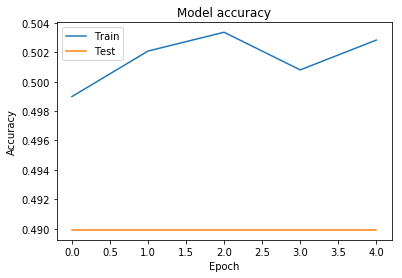

In [25]:
# 绘制训练 & 验证的准确率值
plt.plot(history_large_lr.history['acc'])
plt.plot(history_large_lr.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

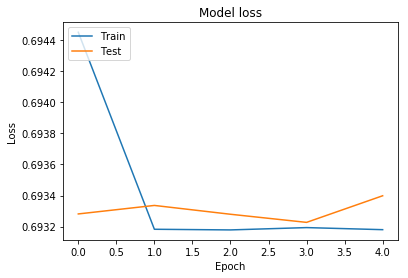

In [26]:
plt.plot(history_large_lr.history['loss'])
plt.plot(history_large_lr.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 思考

以上的优化器对比都是在训练初期轮数较少的情况下进行，但是在轮数较多或者出现鞍点等情况时，不同的优化器都有不一样的表现。可以尝试用更多的轮数对比不同的优化器，重新审视各个模型在训练各个阶段的表现。